In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,9)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns

In [2]:
# Load Dataset
def preprocess(file):
    data = pd.read_csv(file)
    HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
    HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
    HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
    HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
    HUElec = HUElec.set_index('Datetime')
    HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

    return HUElec

In [3]:
file = 'C:\\Users\\moham\\OneDrive - De Montfort University\\Final Project\\Master_Thesis\\Dataset\\QBElec.csv'

data = preprocess(file)

data.fillna(method='ffill', inplace=True)

In [4]:
df = data.resample(rule='D').mean()

originaldf = data.resample(rule='D').mean()

df.index

DatetimeIndex(['2008-03-03', '2008-03-04', '2008-03-05', '2008-03-06',
               '2008-03-07', '2008-03-08', '2008-03-09', '2008-03-10',
               '2008-03-11', '2008-03-12',
               ...
               '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23',
               '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27',
               '2022-02-28', '2022-03-01'],
              dtype='datetime64[ns]', name='Datetime', length=5112, freq='D')

In [5]:
df = df.loc[:'2019-12-30']
originaldf = originaldf.loc[:'2019-12-30']

In [6]:
df.tail()

,value
Datetime,
2019-12-26,33.510417
2019-12-27,32.541667
2019-12-28,29.500000
2019-12-29,25.687479
2019-12-30,30.187500


<AxesSubplot:xlabel='Datetime', ylabel='value'>

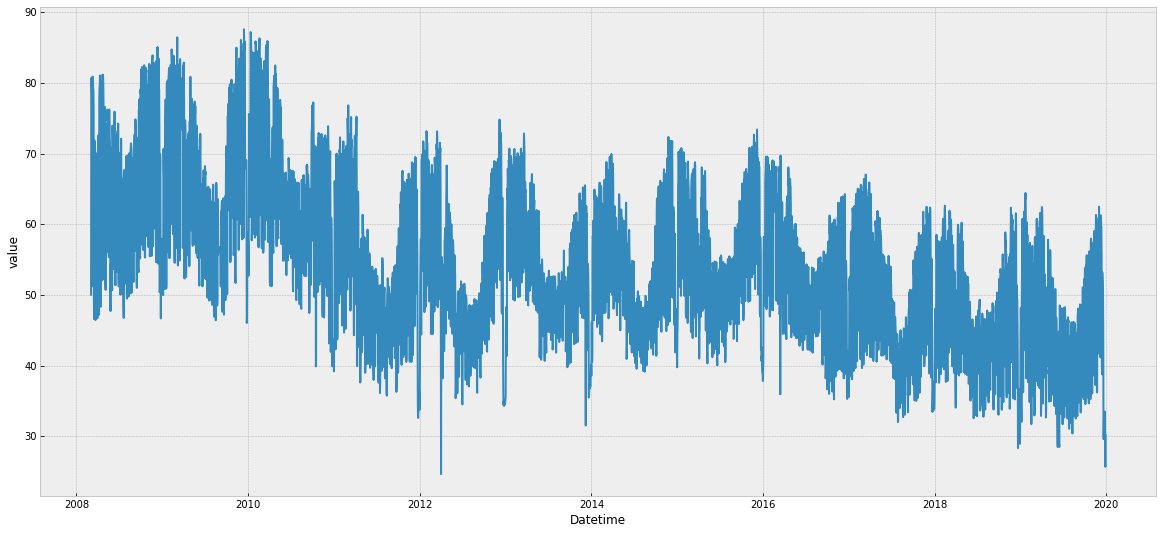

In [7]:
sns.lineplot(x=df.index, y='value', data=df)

<AxesSubplot:xlabel='Datetime', ylabel='value'>

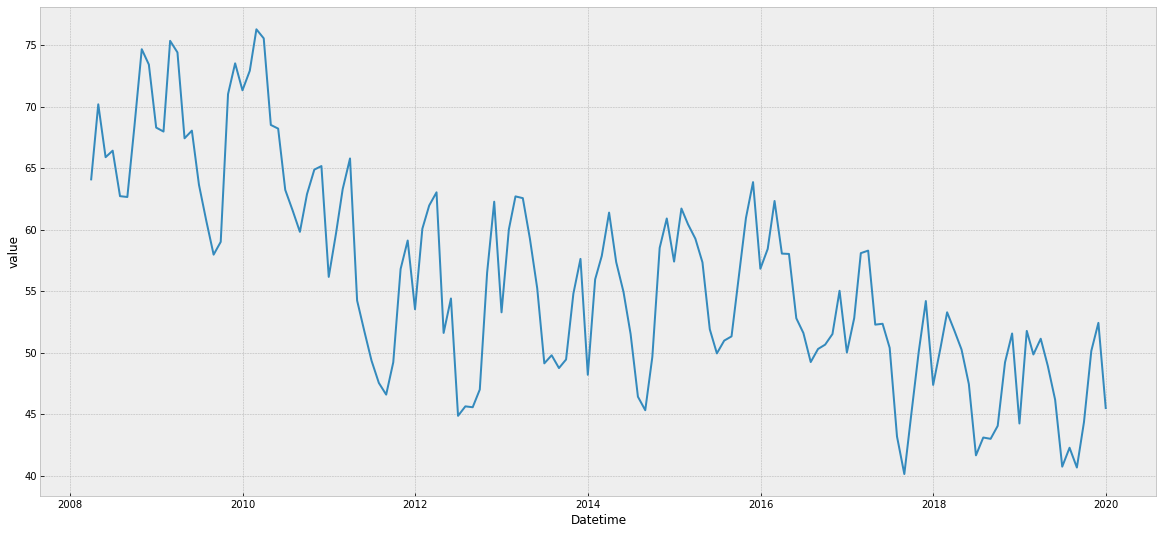

In [9]:
df_by_month = df.resample(rule='M').mean()

sns.lineplot(x=df_by_month.index, y='value', data=df_by_month)

In [10]:
# Splitting the data
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(3456, 1) (864, 1)


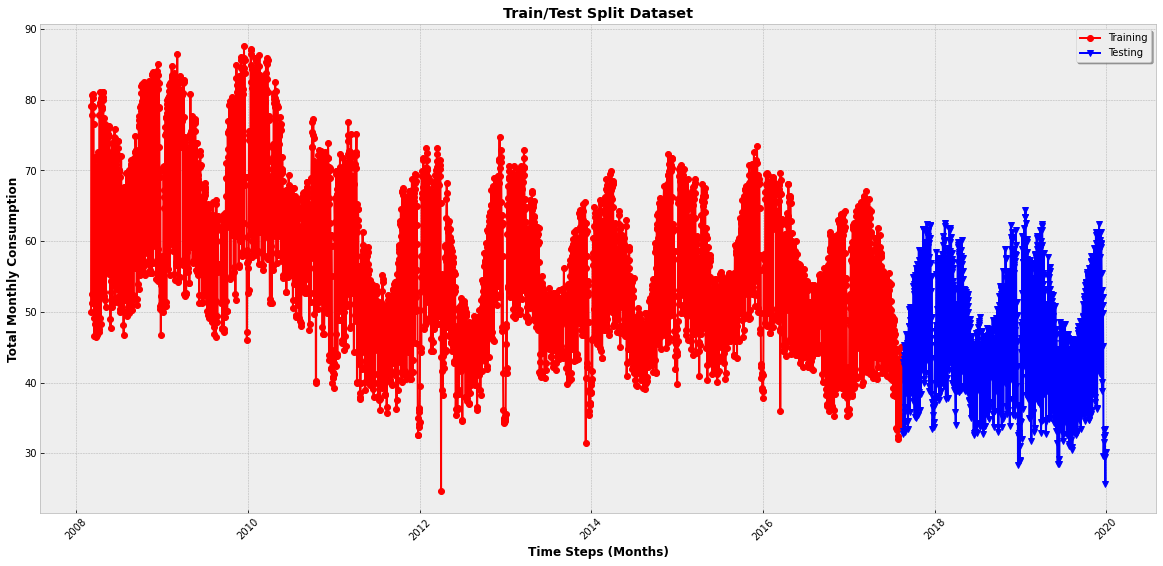

In [11]:
# plt.figure(figsize=(30,9))
plt.plot(train.index, train.value, 'r', label='Training', marker='o')
plt.plot(test.index, test.value, 'b', label='Testing', marker='v')
plt.legend(shadow=True)
plt.ylabel('Total Monthly Consumption',fontweight='bold')
plt.xlabel('Time Steps (Months)',fontweight='bold')
plt.xticks(rotation=45)
plt.title('Train/Test Split Dataset',fontweight='bold');

In [12]:
train.tail()

,value
Datetime,
2017-08-14,43.005208
2017-08-15,43.229167
2017-08-16,43.619792
2017-08-17,43.807292
2017-08-18,42.197917


In [13]:
len(test)

864

In [14]:
scaler = MinMaxScaler()

scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

<ipython-input-14-b16a5f7f4721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['value'] = scaler.transform(train[['value']])
<ipython-input-14-b16a5f7f4721>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['value'] = scaler.transform(test[['value']])


In [15]:
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []

    for i in range(len(X) - time_step):
        v = X.iloc[i:(i+time_step)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_step])

    return np.array(Xs), np.array(ys)

In [16]:
TIME_STEPS = 30 # Taking 2 week time steps to predict the next day:  Taking 23 hours to predict the next hour

X_train, y_train = create_dataset(train, train.value, time_step=TIME_STEPS)
X_test, y_test = create_dataset(test, test.value, time_step=TIME_STEPS)

In [17]:
# create_dataset converts the data to this format [samples, time_steps, n_features]

print(X_train.shape, y_train.shape)

(3426, 30, 1) (3426,)


In [18]:
print(X_test.shape, y_test.shape)

(834, 30, 1) (834,)


In [19]:
X_train[0][0].shape

(1,)

In [48]:
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.summary()

# model = Sequential()
# model.add(Bidirectional(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)))
# model.add(Bidirectional(LSTM(units=128)))
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=1))

# model = Sequential()

# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu'), name = 'input'))

# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))

# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))

# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))

# model.add(Bidirectional(LSTM(128, return_sequences=True, activation='relu')))

# model.add(BatchNormalization(name='Normalization'))

# model.add(Dropout(0.2))

# model.add(LSTM(1, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, activation='relu', name='Output'))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           66560     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [49]:
from keras.callbacks import *

es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

In [50]:
model.compile(optimizer='adam', loss='mse')

In [51]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, callbacks=es, shuffle=False)

Epoch 1/50
193/193 [==============================] - 7s 25ms/step - loss: 0.0404 - val_loss: 0.0195
Epoch 2/50
193/193 [==============================] - 4s 21ms/step - loss: 0.0254 - val_loss: 0.0190
Epoch 3/50
193/193 [==============================] - 4s 20ms/step - loss: 0.0238 - val_loss: 0.0190
Epoch 4/50
193/193 [==============================] - 4s 21ms/step - loss: 0.0230 - val_loss: 0.0193


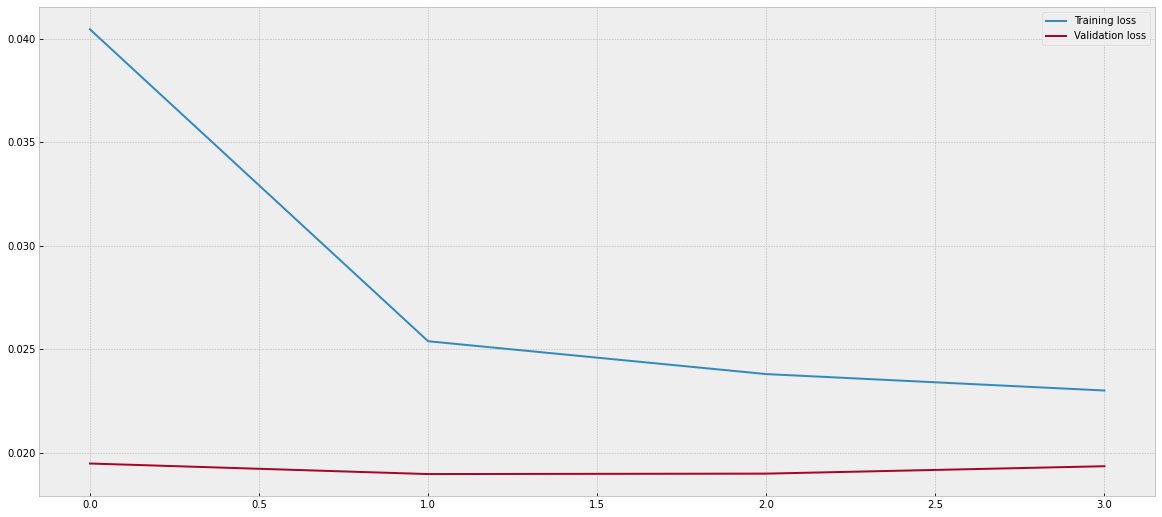

In [52]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [53]:
y_pred = model.predict(X_test)

In [54]:
y_train_inv = scaler.inverse_transform(y_train.reshape(1,-1))
y_test_inv = scaler.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [55]:
from sklearn.metrics import *

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}%')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2: {r2_score(y_test, y_pred)*100} %')

MAE: 0.11021574355449859
MAPE: 0.4769361094185149%
MSE: 0.016965627952129414
RMSE: 0.13025217062348488
R2: 16.507595504631823 %


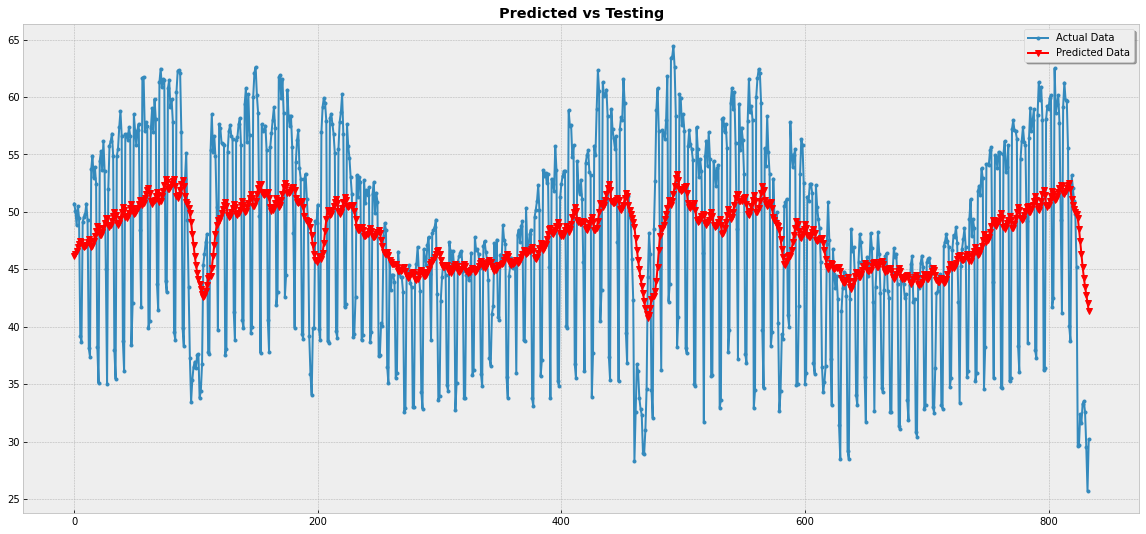

In [56]:
plt.plot(y_test_inv.flatten(), marker='.', label='Actual Data')
plt.plot(y_pred_inv.flatten(), marker='v', color='r', label='Predicted Data')
plt.title('Predicted vs Testing', fontweight='bold')
plt.legend(shadow=True);

In [57]:
len(X_test)

834

In [90]:
n_future = len(X_test) # Predicting the next 3 months from last data entry
forecast_period_dates = pd.date_range('2019-09-20', periods=len(X_test), freq='1d')

In [91]:
forecast = model.predict(X_test[-n_future:])

In [92]:
y_pred_future = scaler.inverse_transform(forecast)

In [93]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [94]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'value':np.ravel(y_pred_future)})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'], origin='unix')

df_forecast.head()

ValueError: All arrays must be of the same length

In [87]:
# data = originaldf.copy()
# data = data[:-1]
data1 = originaldf.reset_index()
df1 = data1

In [88]:
original = df1[['Datetime', 'value']];
original['Datetime']=pd.to_datetime(original['Datetime']);
original = original.loc[original['Datetime'] >= '2019-05-12'];

original

,Datetime,value
4087,2019-05-12,35.958333
4088,2019-05-13,51.333333
4089,2019-05-14,50.958333
4090,2019-05-15,52.437500
4091,2019-05-16,52.395833
...,...,...
4315,2019-12-26,33.510417
4316,2019-12-27,32.541667
4317,2019-12-28,29.500000
4318,2019-12-29,25.687479


C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


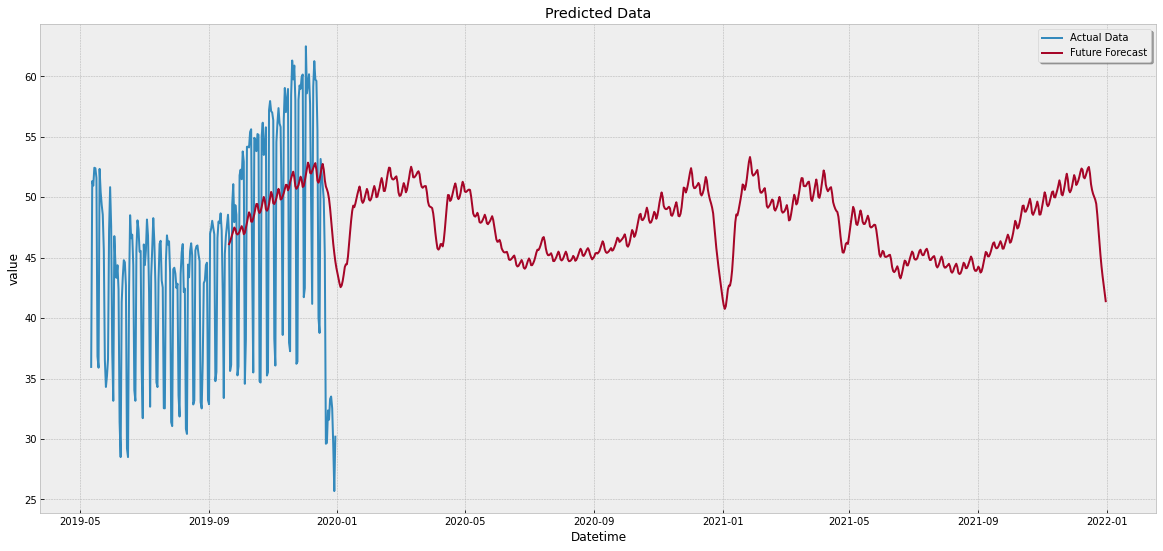

In [89]:
sns.lineplot(original['Datetime'], original['value'], label='Actual Data');
sns.lineplot(df_forecast['Date'], df_forecast['value'], label='Future Forecast');
plt.title('Predicted Data');
plt.legend(shadow=True);

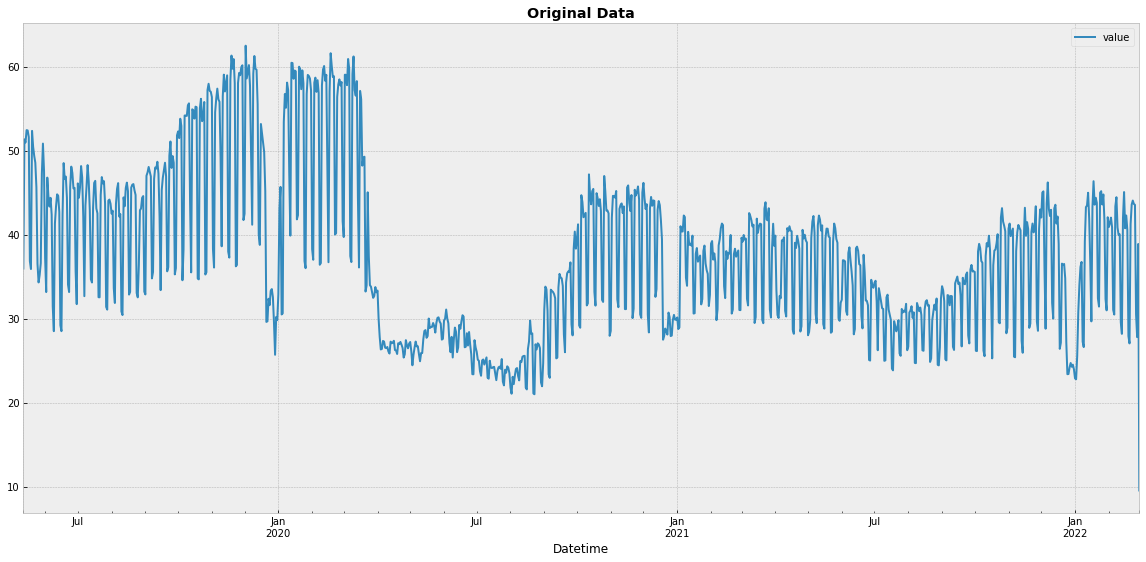

In [47]:
full_data = data.resample(rule='d').mean().copy()

full_data.loc['2019-05-12':].plot()
plt.title('Original Data', fontweight='bold')
plt.show()